# SAE Concept Evaluation Results

Visualizations for the InterPLM SAE concept evaluation pipeline results.
- ESM2-8M (layer 4)
- ESM2-650M (layer 24)
- Evo2-7B (fwd + revcomp)
- Evo2-40B (fwd + revcomp)

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_theme(style="whitegrid")

BASE = Path("..").resolve()

# All model configs: (label, results_dir_name)
MODEL_CONFIGS = {
    "ESM2-8M": "esm2_8m_layer_4",
    "ESM2-650M": "esm2_650m_layer_24",
    "Evo2-7B (fwd)": "evo2_7b_fwd",
    "Evo2-7B (revcomp)": "evo2_7b_revcomp",
    "Evo2-40B (fwd)": "evo2_40b_fwd",
    "Evo2-40B (revcomp)": "evo2_40b_revcomp",
}

# Color/style scheme: same color per model family, solid=fwd, dashed=revcomp
MODEL_COLORS = {
    "ESM2-8M": "C0", "ESM2-650M": "C1",
    "Evo2-7B (fwd)": "C2", "Evo2-7B (revcomp)": "C2",
    "Evo2-40B (fwd)": "C3", "Evo2-40B (revcomp)": "C3",
}
MODEL_LINESTYLES = {
    "ESM2-8M": "-", "ESM2-650M": "-",
    "Evo2-7B (fwd)": "-", "Evo2-7B (revcomp)": "--",
    "Evo2-40B (fwd)": "-", "Evo2-40B (revcomp)": "--",
}

# Load heldout top pairings (best feature per concept, F1>0.5)
top_pairings = {}
all_pairings = {}
for label, cfg in MODEL_CONFIGS.items():
    top_path = BASE / f"results/{cfg}/test_counts/heldout_top_pairings.csv"
    all_path = BASE / f"results/{cfg}/test_counts/heldout_all_top_pairings.csv"
    if top_path.exists():
        top_pairings[label] = pd.read_csv(top_path, index_col=0)
    if all_path.exists():
        all_pairings[label] = pd.read_csv(all_path)

for label, df in top_pairings.items():
    n_all = len(all_pairings.get(label, []))
    print(f"{label:25s}  top: {len(df):4d} concepts,  all (F1>0.5): {n_all:5d} pairs")

# Load paper results for comparison
paper = pd.read_csv(BASE / "paper_results/2026-02-18T00-47_export.csv")
print(f"\nPaper results: {len(paper)} concepts")

ESM2-8M                    top:  531 concepts,  all (F1>0.5):  2405 pairs
ESM2-650M                  top:  569 concepts,  all (F1>0.5):  1319 pairs
Evo2-7B (fwd)              top:  424 concepts,  all (F1>0.5):   327 pairs
Evo2-7B (revcomp)          top:  423 concepts,  all (F1>0.5):   260 pairs
Evo2-40B (fwd)             top:  439 concepts,  all (F1>0.5):   750 pairs
Evo2-40B (revcomp)         top:  452 concepts,  all (F1>0.5):   759 pairs

Paper results: 132 concepts


## Summary Statistics

In [58]:
def summary_stats(df, label):
    return {
        "Model": label,
        "Concepts identified": len(df),
        "Unique features used": df["feature"].nunique(),
        "Mean F1 (per domain)": df["f1_per_domain"].mean(),
        "Median F1 (per domain)": df["f1_per_domain"].median(),
        "Mean Precision": df["precision"].mean(),
        "Mean Recall (per domain)": df["recall_per_domain"].mean(),
        "F1 >= 0.9": (df["f1_per_domain"] >= 0.9).sum(),
        "F1 >= 0.8": (df["f1_per_domain"] >= 0.8).sum(),
        "F1 >= 0.7": (df["f1_per_domain"] >= 0.7).sum(),
    }

stats = pd.DataFrame([summary_stats(df, label) for label, df in top_pairings.items()])
stats = stats.set_index("Model")
stats.style.format({
    "Mean F1 (per domain)": "{:.4f}",
    "Median F1 (per domain)": "{:.4f}",
    "Mean Precision": "{:.4f}",
    "Mean Recall (per domain)": "{:.4f}",
})

,Concepts identified,Unique features used,Mean F1 (per domain),Median F1 (per domain),Mean Precision,Mean Recall (per domain),F1 >= 0.9,F1 >= 0.8,F1 >= 0.7
Model,,,,,,,,,
ESM2-8M,531,443,0.2880,0.1190,0.2669,0.6003,46,67,85
ESM2-650M,569,497,0.4374,0.3830,0.3836,0.7592,89,129,166
Evo2-7B (fwd),424,387,0.2429,0.1231,0.2433,0.4290,23,37,48
Evo2-7B (revcomp),423,385,0.2593,0.1379,0.2630,0.4068,20,32,48
Evo2-40B (fwd),439,403,0.3806,0.2945,0.3892,0.5403,41,78,109
Evo2-40B (revcomp),452,411,0.3900,0.3030,0.3979,0.5373,52,90,123


## 1. F1 Distribution Comparison (8M vs 650M)

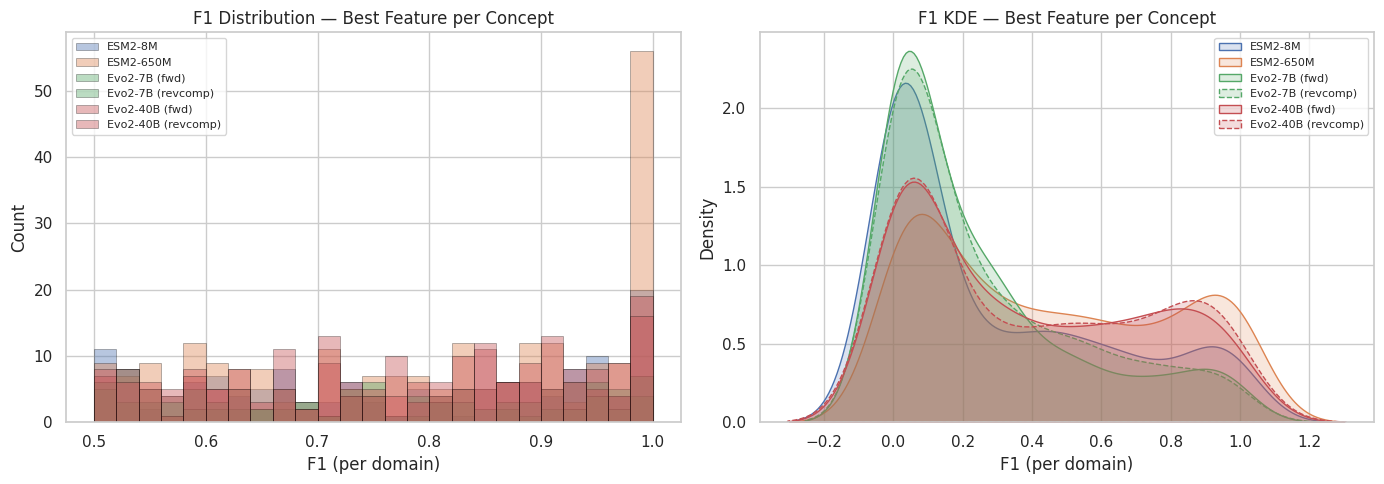

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax = axes[0]
bins = np.linspace(0.5, 1.0, 26)
for label, df in top_pairings.items():
    ax.hist(df["f1_per_domain"], bins=bins, alpha=0.4, label=label,
            edgecolor="black", linewidth=0.5, color=MODEL_COLORS[label])
ax.set_xlabel("F1 (per domain)")
ax.set_ylabel("Count")
ax.set_title("F1 Distribution — Best Feature per Concept")
ax.legend(fontsize=8)

# KDE
ax = axes[1]
for label, df in top_pairings.items():
    sns.kdeplot(df["f1_per_domain"], ax=ax, label=label, fill=True, alpha=0.2,
                color=MODEL_COLORS[label], linestyle=MODEL_LINESTYLES[label])
ax.set_xlabel("F1 (per domain)")
ax.set_ylabel("Density")
ax.set_title("F1 KDE — Best Feature per Concept")
ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

## 2. Top 20 Concepts by F1

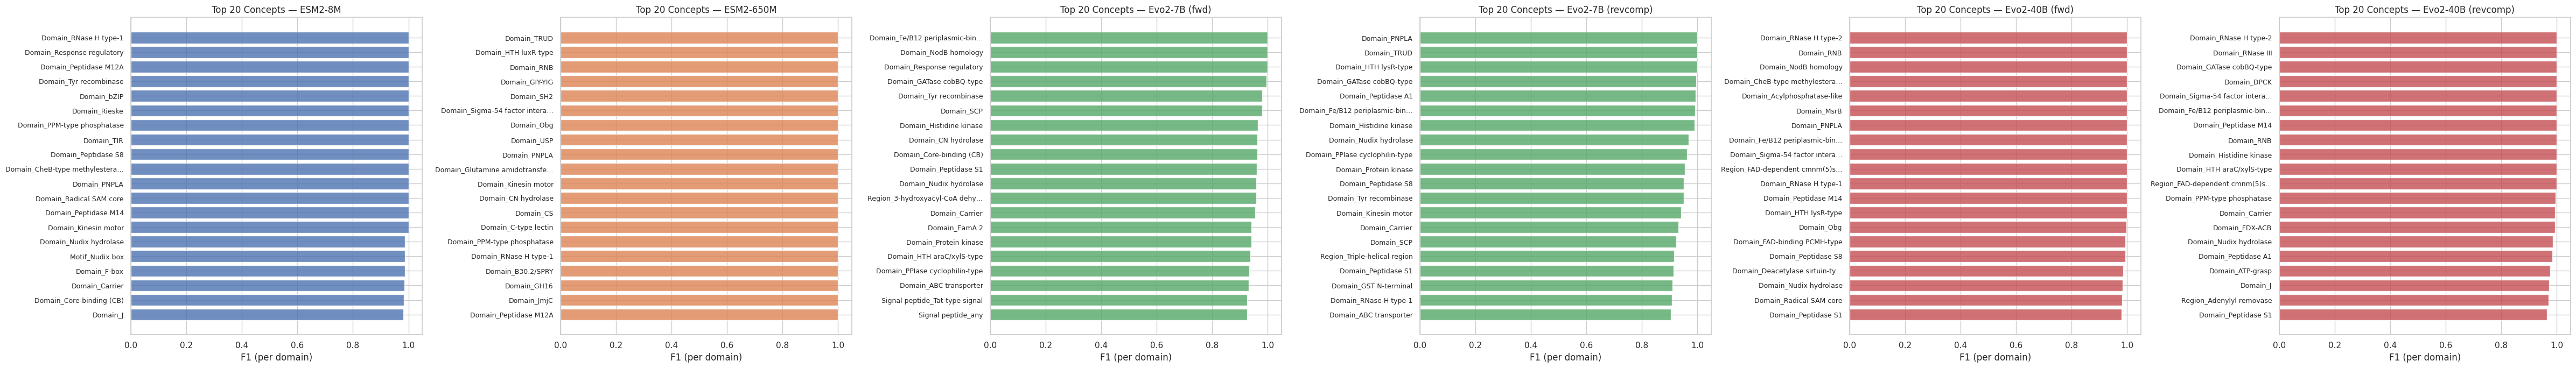

In [60]:
def shorten_concept(name, max_len=30):
    """Shorten concept name for display."""
    if len(name) <= max_len:
        return name
    return name[:max_len - 1] + "\u2026"

n_models = len(top_pairings)
fig, axes = plt.subplots(1, n_models, figsize=(8 * n_models, 7))
if n_models == 1:
    axes = [axes]

for ax, (label, df) in zip(axes, top_pairings.items()):
    df_filt = df[~df["concept"].str.startswith("amino acid")]
    top20 = df_filt.nlargest(20, "f1_per_domain")
    display_names = [shorten_concept(c) for c in top20["concept"]]
    
    bars = ax.barh(range(len(top20)), top20["f1_per_domain"].values,
                   color=MODEL_COLORS[label], alpha=0.8)
    ax.set_yticks(range(len(top20)))
    ax.set_yticklabels(display_names, fontsize=9)
    ax.set_xlabel("F1 (per domain)")
    ax.set_title(f"Top 20 Concepts — {label}")
    ax.set_xlim(0, 1.05)
    ax.invert_yaxis()

plt.tight_layout()
plt.show()

## 3. Precision vs Recall Scatter

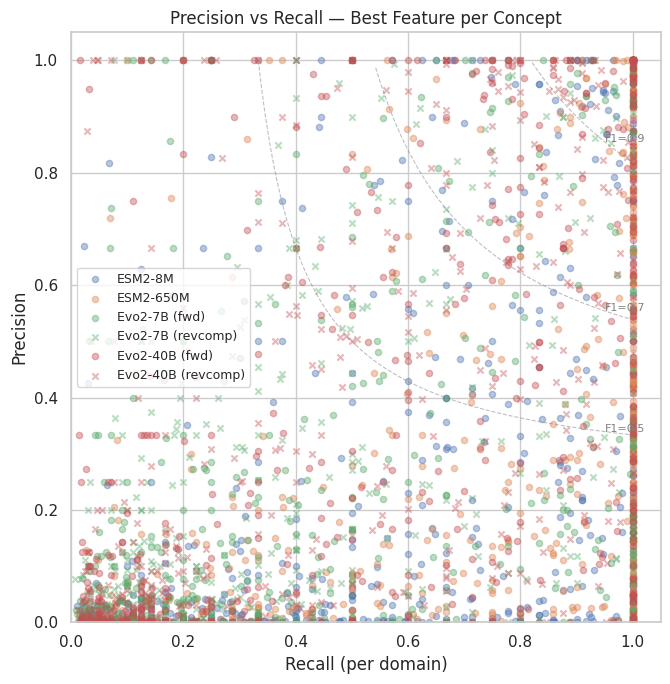

In [61]:
fig, ax = plt.subplots(figsize=(8, 7))

for label, df in top_pairings.items():
    ax.scatter(df["recall_per_domain"], df["precision"], alpha=0.4, s=20,
               label=label, color=MODEL_COLORS[label],
               marker="o" if "revcomp" not in label else "x")

# F1 iso-lines
for f1_val in [0.5, 0.7, 0.9]:
    r = np.linspace(0.01, 1, 200)
    p = (f1_val * r) / (2 * r - f1_val)
    mask = (p > 0) & (p <= 1)
    ax.plot(r[mask], p[mask], "--", color="gray", alpha=0.5, linewidth=0.8)
    idx = np.argmin(np.abs(r - 0.95))
    if mask[idx]:
        ax.annotate(f"F1={f1_val}", (r[idx], p[idx]), fontsize=8, color="gray")

ax.set_xlabel("Recall (per domain)")
ax.set_ylabel("Precision")
ax.set_title("Precision vs Recall — Best Feature per Concept")
ax.set_xlim(0, 1.05)
ax.set_ylim(0, 1.05)
ax.legend(fontsize=9)
ax.set_aspect("equal")
plt.tight_layout()
plt.show()

## 4. Concept Category Breakdown

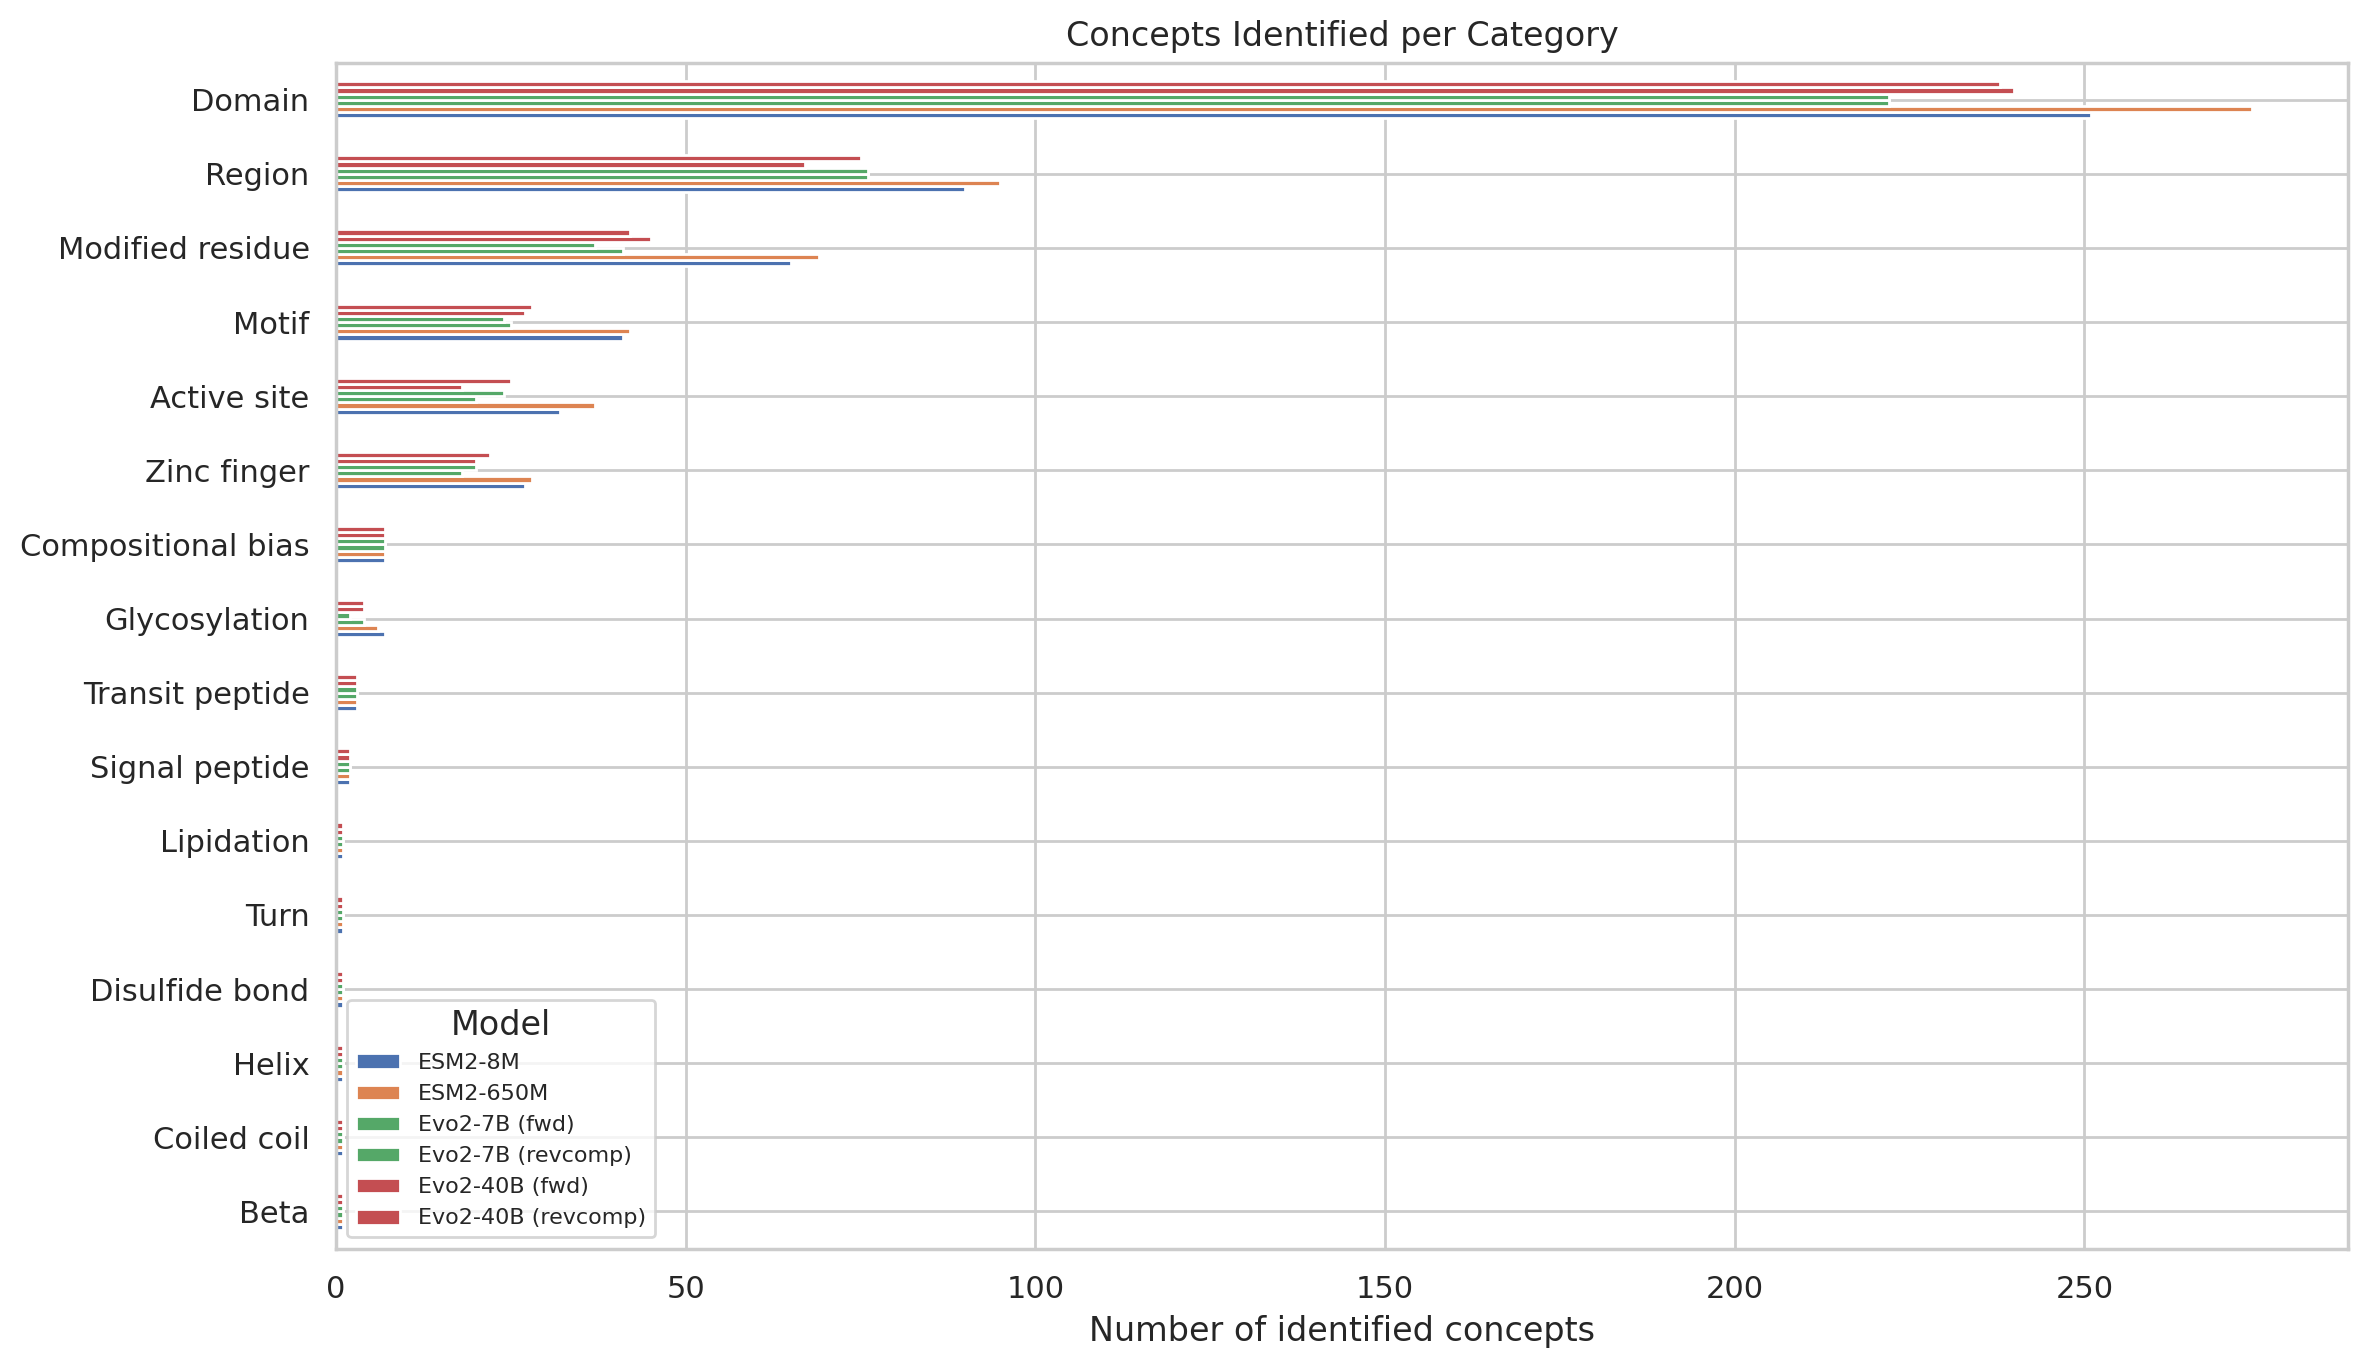


Category counts:
                    ESM2-8M  ESM2-650M  Evo2-7B (fwd)  Evo2-7B (revcomp)  \
concept                                                                    
Active site              32         37             20                 24   
Beta                      1          1              1                  1   
Coiled coil               1          1              1                  1   
Compositional bias        7          7              7                  7   
Disulfide bond            1          1              1                  1   
Domain                  251        274            222                222   
Glycosylation             7          6              4                  2   
Helix                     1          1              1                  1   
Lipidation                1          1              1                  1   
Modified residue         65         69             41                 37   
Motif                    41         42             25                 

In [69]:
def extract_category(concept):
    """Extract the category prefix from a concept name."""
    if "_" in concept:
        prefix = concept.split("_")[0]
    else:
        prefix = concept.split()[0]
    category_map = {
        "Domain": "Domain", "Motif": "Motif", "Region": "Region",
        "Active": "Active site", "Binding": "Binding site",
        "Signal": "Signal peptide", "Transit": "Transit peptide",
        "Zinc": "Zinc finger", "Compositional": "Compositional bias",
        "Modified": "Modified residue", "Disulfide": "Disulfide bond",
        "Coiled": "Coiled coil", "Disordered": "Disordered",
        "amino": "Amino acid identity",
    }
    return category_map.get(prefix, prefix)

cat_counts = {}
for label, df in top_pairings.items():
    cat_counts[label] = df["concept"].apply(extract_category).value_counts()

cat_df = pd.DataFrame(cat_counts).fillna(0).astype(int)
cat_df["total"] = cat_df.sum(axis=1)
cat_df = cat_df.sort_values("total", ascending=True).drop(columns="total")

fig, ax = plt.subplots(figsize=(12, 7), dpi=200)
cat_df.plot.barh(ax=ax, color=[MODEL_COLORS[c] for c in cat_df.columns])
ax.set_xlabel("Number of identified concepts")
ax.set_ylabel("")
ax.set_title("Concepts Identified per Category")
ax.legend(title="Model", fontsize=8)
plt.tight_layout()
plt.show()

print("\nCategory counts:")
print(cat_df.sort_index())

In [70]:
top_pairings["ESM2-8M"][top_pairings["ESM2-8M"]["f1_per_domain"] >= 0.5]

,concept,feature,threshold_pct,precision,recall,recall_per_domain,f1,f1_per_domain,tp,fp,tp_per_domain,is_aa_level_concept
766,Domain_RNase H type-1,3143,0.50,1.000000,0.165566,1.000000,0.284095,1.0,376.0,0.0,16.0,False
464,Domain_Response regulatory,6150,0.60,1.000000,0.141480,1.000000,0.247889,1.0,690.0,0.0,42.0,False
1387,Domain_Peptidase M12A,4184,0.80,1.000000,0.115528,1.000000,0.207127,1.0,93.0,0.0,4.0,False
756,Domain_Tyr recombinase,3925,0.50,1.000000,0.037471,1.000000,0.072235,1.0,96.0,0.0,14.0,False
691,Domain_bZIP,2093,0.15,1.000000,0.027899,1.000000,0.054283,1.0,32.0,0.0,18.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...
1354,Domain_Collagen-like,10003,0.80,0.333333,0.094203,1.000000,0.146893,0.5,13.0,26.0,3.0,False
1086,Domain_ApaG,5866,0.80,0.400000,0.005333,0.666667,0.010526,0.5,6.0,9.0,6.0,False
1312,Domain_Cupin type-1,6355,0.80,0.400000,0.004640,0.666667,0.009174,0.5,2.0,3.0,2.0,False
1314,Domain_GH16,406,0.15,0.750000,0.001397,0.375000,0.002788,0.5,3.0,1.0,3.0,False


In [71]:
top_pairings["ESM2-650M"][top_pairings["ESM2-650M"]["f1_per_domain"] >= 0.5]

,concept,feature,threshold_pct,precision,recall,recall_per_domain,f1,f1_per_domain,tp,fp,tp_per_domain,is_aa_level_concept
1371,Domain_TRUD,1705,0.8,1.000000,0.652080,1.000000,0.789405,1.000000,909.0,0.0,9.0,False
1174,Domain_HTH luxR-type,4623,0.5,1.000000,0.513468,1.000000,0.678532,1.000000,305.0,0.0,9.0,False
1629,Domain_RNB,4735,0.5,1.000000,0.482075,1.000000,0.650540,1.000000,632.0,0.0,4.0,False
661,Domain_GIY-YIG,2148,0.5,1.000000,0.327949,1.000000,0.493919,1.000000,934.0,0.0,36.0,False
1266,Domain_SH2,9221,0.6,1.000000,0.307692,1.000000,0.470588,1.000000,148.0,0.0,5.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...
1829,Region_Catalytic,4701,0.8,0.392488,0.072342,0.711111,0.122167,0.505804,1024.0,1585.0,32.0,False
1568,Domain_HTH rrf2-type,6677,0.8,0.333333,0.010283,1.000000,0.019950,0.500000,4.0,8.0,3.0,False
1447,Domain_EamA 1,8210,0.8,0.333333,0.008889,1.000000,0.017316,0.500000,10.0,20.0,9.0,False
1553,Domain_HIT,6298,0.8,0.352941,0.007916,0.857143,0.015484,0.500000,6.0,11.0,6.0,False


In [75]:
top_pairings["Evo2-40B (fwd)"][top_pairings["Evo2-40B (fwd)"]['concept'] == 'Helix']

,concept,feature,threshold_pct,precision,recall,recall_per_domain,f1,f1_per_domain,tp,fp,tp_per_domain,is_aa_level_concept
1821,Helix,948,0.15,0.060923,0.063942,0.143375,0.062396,0.085511,6830.0,105279.0,1621.0,False


Loading ESM2-8M... 605 concepts, best F1 range: [0.000, 1.000]
Loading ESM2-650M... 605 concepts, best F1 range: [0.002, 1.000]
Loading Evo2-7B (fwd)... 605 concepts, best F1 range: [0.001, 1.000]
Loading Evo2-7B (revcomp)... 605 concepts, best F1 range: [0.000, 1.000]
Loading Evo2-40B (fwd)... 605 concepts, best F1 range: [0.000, 1.000]
Loading Evo2-40B (revcomp)... 605 concepts, best F1 range: [0.001, 1.000]


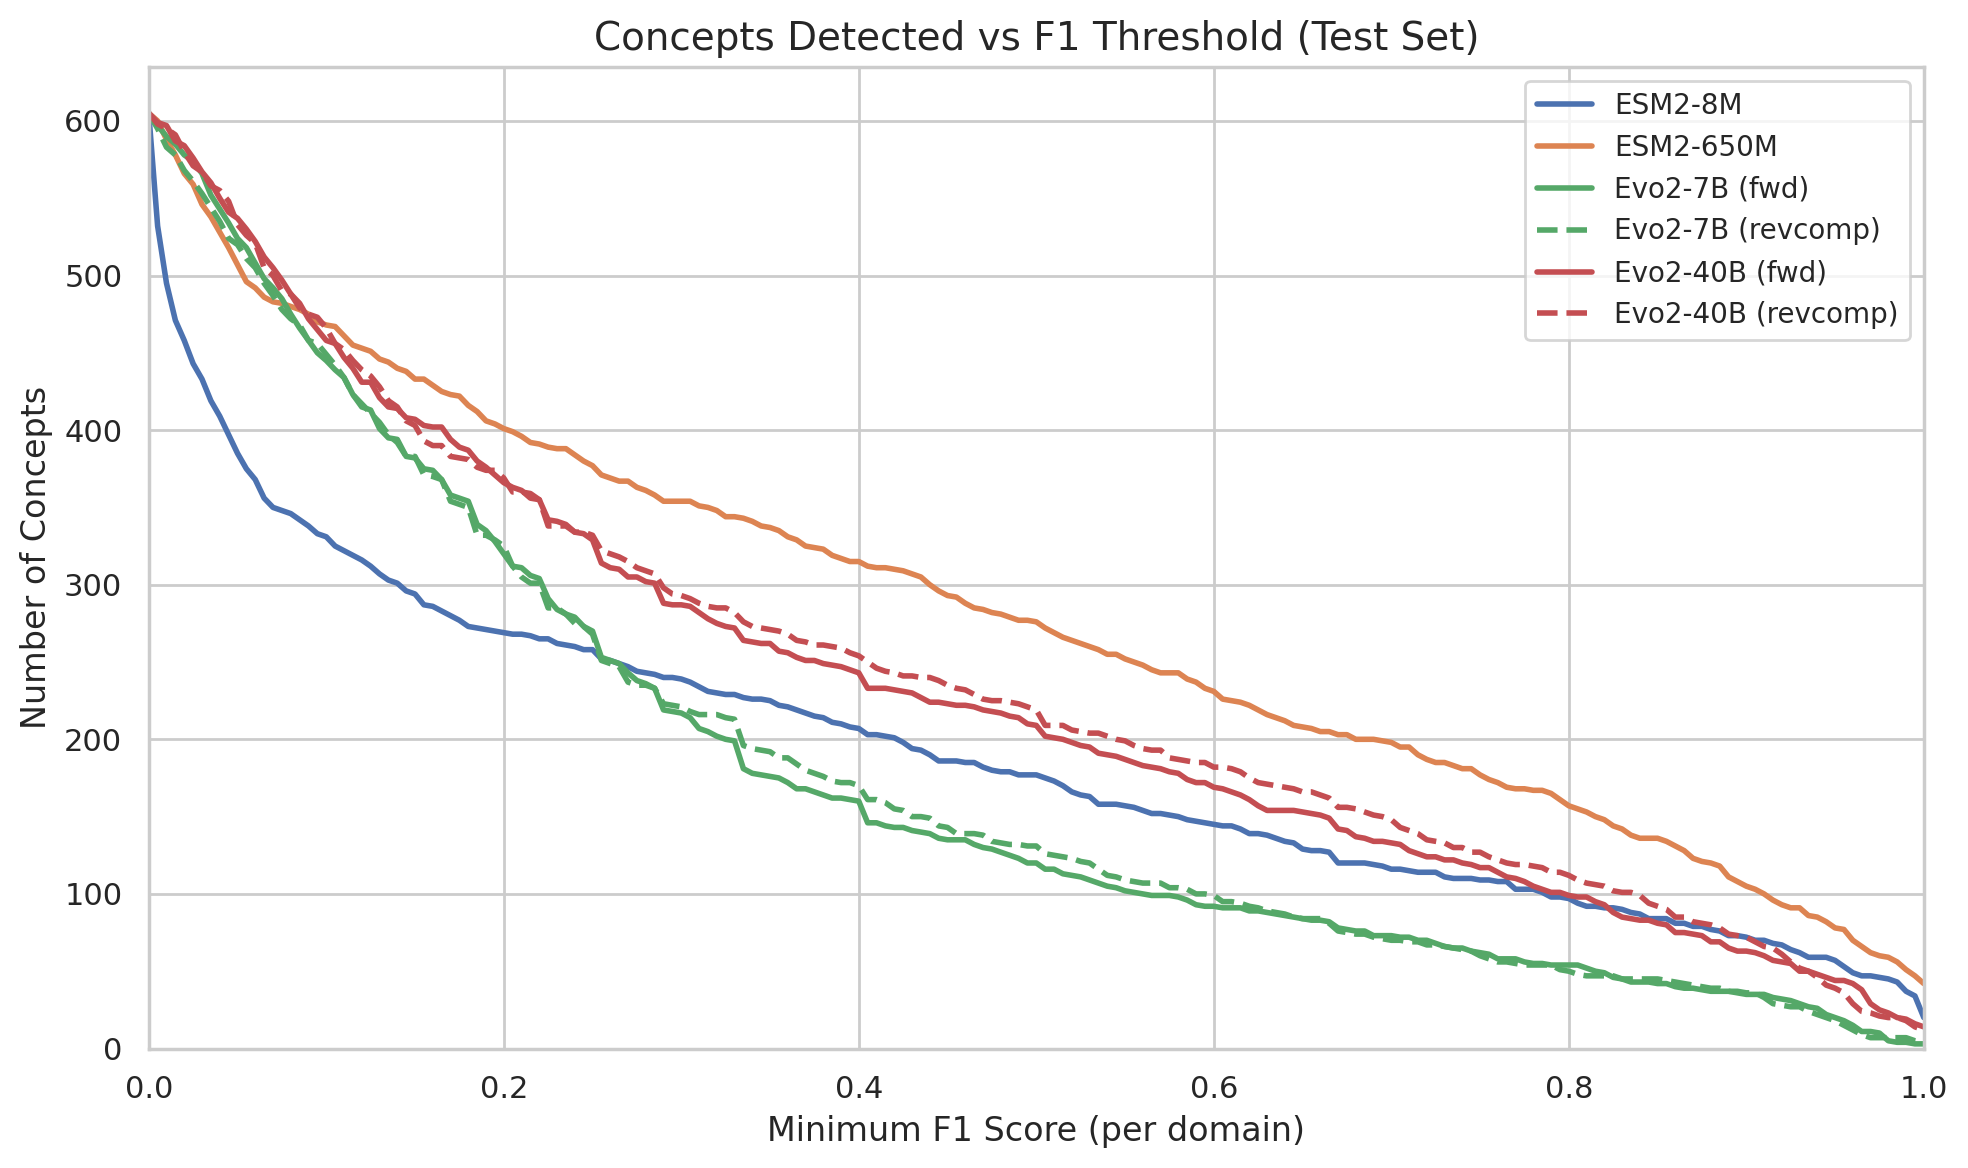


Concepts above F1 threshold:
Threshold   ESM2-8M               ESM2-650M             Evo2-7B (fwd)         Evo2-7B (revcomp)     Evo2-40B (fwd)        Evo2-40B (revcomp)    
0.1         331                   468                   445                   449                   458                   466                   
0.3         239                   354                   217                   221                   287                   293                   
0.5         177                   276                   120                   131                   209                   219                   
0.7         116                   198                   73                    70                    133                   148                   
0.9         72                    105                   35                    36                    63                    72                    


In [67]:
# Number of concepts vs minimum F1 threshold
# Uses raw test concept_f1_scores.csv (best feature per concept)

import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_theme(style="whitegrid")
BASE = Path("..").resolve()

configs = {
    "ESM2-8M": "esm2_8m_layer_4",
    "ESM2-650M": "esm2_650m_layer_24",
    "Evo2-7B (fwd)": "evo2_7b_fwd",
    "Evo2-7B (revcomp)": "evo2_7b_revcomp",
    "Evo2-40B (fwd)": "evo2_40b_fwd",
    "Evo2-40B (revcomp)": "evo2_40b_revcomp",
}

best_f1 = {}
for label, cfg in configs.items():
    path = BASE / f"results/{cfg}/test_counts/concept_f1_scores.csv"
    print(f"Loading {label}...", end=" ", flush=True)
    df = pl.scan_csv(path).select(["concept", "f1_per_domain"])
    best = df.group_by("concept").agg(pl.col("f1_per_domain").max()).collect()
    vals = best["f1_per_domain"].to_numpy()
    best_f1[label] = np.sort(vals)[::-1]
    print(f"{len(vals)} concepts, best F1 range: [{vals.min():.3f}, {vals.max():.3f}]")

# Plot: for each F1 threshold, how many concepts have best F1 >= threshold
thresholds = np.linspace(0, 1, 201)

fig, ax = plt.subplots(figsize=(10, 6), dpi=200)

# Same color per model, solid=fwd, dashed=revcomp
colors = {
    "ESM2-8M": "C0", "ESM2-650M": "C1",
    "Evo2-7B (fwd)": "C2", "Evo2-7B (revcomp)": "C2",
    "Evo2-40B (fwd)": "C3", "Evo2-40B (revcomp)": "C3",
}
linestyles = {
    "ESM2-8M": "-", "ESM2-650M": "-",
    "Evo2-7B (fwd)": "-", "Evo2-7B (revcomp)": "--",
    "Evo2-40B (fwd)": "-", "Evo2-40B (revcomp)": "--",
}

for label, vals in best_f1.items():
    counts = [(vals >= t).sum() for t in thresholds]
    ax.plot(thresholds, counts, label=label, linewidth=2,
            color=colors[label], linestyle=linestyles[label])

ax.set_xlabel("Minimum F1 Score (per domain)", fontsize=12)
ax.set_ylabel("Number of Concepts", fontsize=12)
ax.set_title("Concepts Detected vs F1 Threshold (Test Set)", fontsize=14)
ax.legend(fontsize=10)
ax.set_xlim(0, 1)
ax.set_ylim(bottom=0)
plt.tight_layout()
plt.show()

# Print summary table
print("\nConcepts above F1 threshold:")
print(f"{'Threshold':<12}", end="")
for label in best_f1:
    print(f"{label:<22}", end="")
print()
for t in [0.1, 0.3, 0.5, 0.7, 0.9]:
    print(f"{t:<12.1f}", end="")
    for label, vals in best_f1.items():
        print(f"{(vals >= t).sum():<22}", end="")
    print()

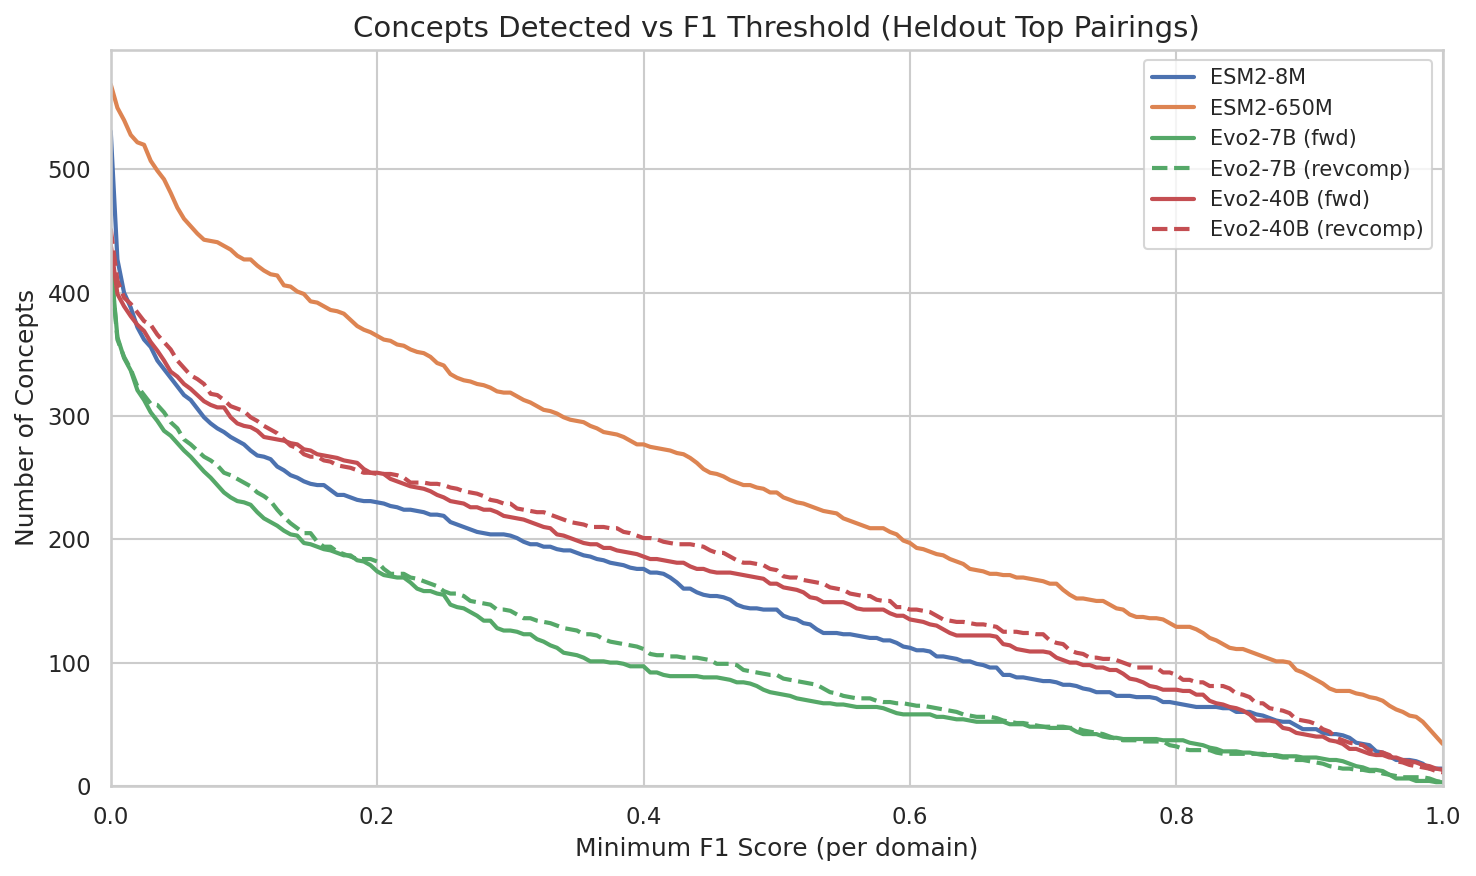


Concepts above F1 threshold (heldout):
Threshold   ESM2-8M               ESM2-650M             Evo2-7B (fwd)         Evo2-7B (revcomp)     Evo2-40B (fwd)        Evo2-40B (revcomp)    
0.1         277                   427                   230                   246                   292                   304                   
0.3         203                   319                   126                   142                   218                   229                   
0.5         143                   238                   75                    90                    164                   175                   
0.7         85                    166                   48                    48                    109                   123                   
0.9         46                    89                    23                    20                    41                    52                    


In [68]:
# Number of concepts vs minimum F1 threshold (heldout top pairings)

thresholds = np.linspace(0, 1, 201)

fig, ax = plt.subplots(figsize=(10, 6), dpi=150)

for label, df in top_pairings.items():
    vals = df["f1_per_domain"].sort_values(ascending=False).values
    counts = [(vals >= t).sum() for t in thresholds]
    ax.plot(thresholds, counts, label=label, linewidth=2,
            color=MODEL_COLORS[label], linestyle=MODEL_LINESTYLES[label])

ax.set_xlabel("Minimum F1 Score (per domain)", fontsize=12)
ax.set_ylabel("Number of Concepts", fontsize=12)
ax.set_title("Concepts Detected vs F1 Threshold (Heldout Top Pairings)", fontsize=14)
ax.legend(fontsize=10)
ax.set_xlim(0, 1)
ax.set_ylim(bottom=0)
plt.tight_layout()
plt.show()

# Print summary table
print("\nConcepts above F1 threshold (heldout):")
print(f"{'Threshold':<12}", end="")
for label in top_pairings:
    print(f"{label:<22}", end="")
print()
for t in [0.1, 0.3, 0.5, 0.7, 0.9]:
    print(f"{t:<12.1f}", end="")
    for label, df in top_pairings.items():
        n = (df["f1_per_domain"] >= t).sum()
        print(f"{n:<22}", end="")
    print()

## 5. Our Results vs Paper (ESM2-8M)

In [ ]:
top_8m = top_pairings["ESM2-8M"]

def paper_concept_to_ours(paper_concept):
    """Convert paper concept format to our format."""
    paper_concept = paper_concept.strip()
    if "(" in paper_concept and paper_concept.endswith(")"):
        idx = paper_concept.rfind("(")
        name = paper_concept[:idx].strip()
        ctype = paper_concept[idx+1:-1].strip()
        return f"{ctype}_{name}"
    return paper_concept

paper["concept_ours"] = paper["Concept"].apply(paper_concept_to_ours)

merged = paper.merge(top_8m, left_on="concept_ours", right_on="concept", suffixes=("_paper", "_ours"))
print(f"Shared concepts between paper and our 8M results: {len(merged)} / {len(paper)} paper concepts")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

ax = axes[0]
ax.scatter(merged["F1"].astype(float), merged["f1"], alpha=0.6, s=25)
ax.plot([0, 1], [0, 1], "k--", alpha=0.5, linewidth=1)
ax.set_xlabel("Paper F1 (per AA)")
ax.set_ylabel("Our F1 (per AA)")
ax.set_title("Paper vs Our Results — Per-AA F1")
ax.set_xlim(0.4, 1.05)
ax.set_ylim(0.4, 1.05)
ax.set_aspect("equal")

ax = axes[1]
ax.scatter(merged["F1"].astype(float), merged["f1_per_domain"], alpha=0.6, s=25)
ax.plot([0, 1], [0, 1], "k--", alpha=0.5, linewidth=1)
ax.set_xlabel("Paper F1 (per AA)")
ax.set_ylabel("Our F1 (per domain)")
ax.set_title("Paper vs Our Results — Per-Domain F1")
ax.set_xlim(0.4, 1.05)
ax.set_ylim(0.4, 1.05)
ax.set_aspect("equal")

plt.tight_layout()
plt.show()

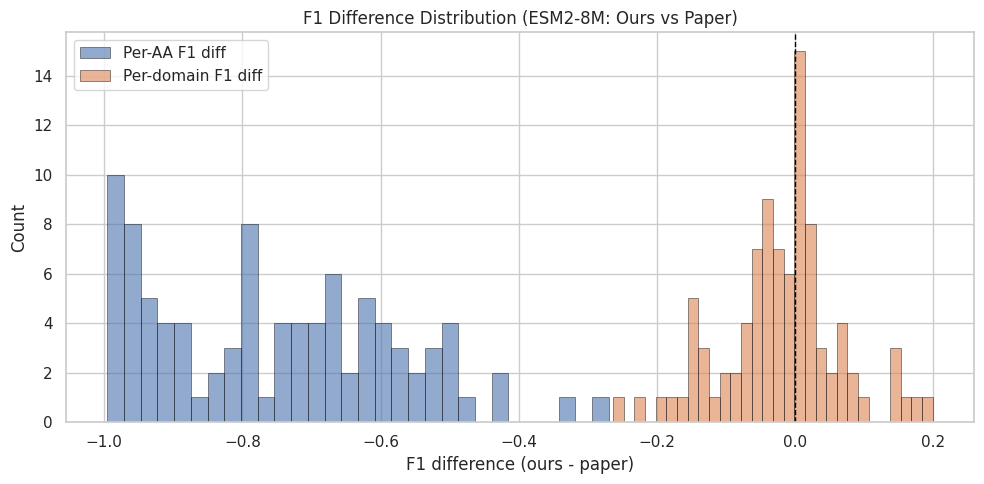

Per-AA F1 diff — mean: -0.7508, median: -0.7598
Per-domain F1 diff — mean: -0.0212, median: -0.0136


In [8]:
# Distribution of F1 differences (ours - paper)
merged["f1_diff"] = merged["f1"] - merged["F1"].astype(float)
merged["f1_domain_diff"] = merged["f1_per_domain"] - merged["F1"].astype(float)

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(merged["f1_diff"], bins=30, alpha=0.6, label="Per-AA F1 diff", edgecolor="black", linewidth=0.5)
ax.hist(merged["f1_domain_diff"], bins=30, alpha=0.6, label="Per-domain F1 diff", edgecolor="black", linewidth=0.5)
ax.axvline(0, color="black", linestyle="--", linewidth=1)
ax.set_xlabel("F1 difference (ours - paper)")
ax.set_ylabel("Count")
ax.set_title("F1 Difference Distribution (ESM2-8M: Ours vs Paper)")
ax.legend()
plt.tight_layout()
plt.show()

print(f"Per-AA F1 diff — mean: {merged['f1_diff'].mean():.4f}, median: {merged['f1_diff'].median():.4f}")
print(f"Per-domain F1 diff — mean: {merged['f1_domain_diff'].mean():.4f}, median: {merged['f1_domain_diff'].median():.4f}")

In [9]:
# Show concepts where we differ most from the paper
print("Top 10 concepts where our per-AA F1 exceeds the paper's:")
print(merged.nlargest(10, "f1_diff")[["concept", "F1", "f1", "f1_diff"]].to_string(index=False))
print()
print("Top 10 concepts where the paper's F1 exceeds ours:")
print(merged.nsmallest(10, "f1_diff")[["concept", "F1", "f1", "f1_diff"]].to_string(index=False))
print()

# Concepts in paper but not in ours
missing = paper[~paper["concept_ours"].isin(top_8m["concept"])]
print(f"\nConcepts in paper but missing from our results: {len(missing)}")
if len(missing) > 0:
    print(missing[["Concept", "concept_ours", "F1"]].to_string(index=False))

Top 10 concepts where our per-AA F1 exceeds the paper's:
                 concept       F1       f1   f1_diff
Domain_Core-binding (CB) 0.989390 0.719593 -0.269797
              Domain_Obg 0.721449 0.389841 -0.331608
            Domain_CBS 2 0.592105 0.165721 -0.426384
       Region_Disordered 0.713588 0.274595 -0.438993
              Domain_RRM 0.504202 0.017743 -0.486459
    Domain_EngA-type G 2 0.500000 0.010186 -0.489814
  Domain_Flavodoxin-like 0.500000 0.002994 -0.497006
     Domain_SpoVT-AbrB 2 0.545455 0.041195 -0.504260
Region_Uridylyl-removing 0.510638 0.005527 -0.505112
   Domain_AB hydrolase-1 0.523810 0.004908 -0.518901

Top 10 concepts where the paper's F1 exceeds ours:
                        concept       F1       f1   f1_diff
                    Domain_GH18 1.000000 0.004403 -0.995597
           Domain_Kinesin motor 1.000000 0.005879 -0.994121
           Domain_Peptidase M14 1.000000 0.006332 -0.993668
Domain_CheB-type methylesterase 1.000000 0.010363 -0.989637
        

## 6. Feature Reuse Analysis

In [ ]:
n_models = len(all_pairings)
ncols = min(3, n_models)
nrows = (n_models + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(7 * ncols, 5 * nrows))
axes = np.array(axes).flatten()

for i, (label, df) in enumerate(all_pairings.items()):
    ax = axes[i]
    feat_counts = df["feature"].value_counts()
    ax.hist(feat_counts.values, bins=range(1, feat_counts.max() + 2),
            alpha=0.7, edgecolor="black", linewidth=0.5, color=MODEL_COLORS[label])
    ax.set_xlabel("Number of concepts per feature")
    ax.set_ylabel("Number of features")
    ax.set_title(f"Feature Reuse — {label} (F1>0.5)")
    ax.text(0.95, 0.95, f"Unique features: {feat_counts.nunique()}\nMax reuse: {feat_counts.max()}",
            transform=ax.transAxes, ha="right", va="top", fontsize=9,
            bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))

# Hide unused axes
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()